In [ ]:
'''
实现之前的疑惑解答：
１．　决策树的生成思路：首先这是一个树的构建，所以要先创建一个树的数据结构，每个结点如果是叶子结点，存储类别，非叶结点，存储当前选取的最大特征，
及左右子结点。无需在结点中存储具体的训练样本
２．　决策树的构建过程就是学习过程，剪枝过程是模型选择过程，预测就是对决策树的搜索，直到符合条件的叶子结点，返回类别

实现中的问题
１．　实现的ID3生成算法，即依据信息增益选择最优特征
    这个算法中，直接对每个特征值构建节点划分子集(而不是特征的某一范围值)，所以对于未在训练集中出现的值，无法预测，报错keyError

sklearn dt:
１）输入必须是数值型
２）构建的是二叉树，依据每个特征是否属于某个范围划分子集
３）因此，对于在训练集未出现过的值，也可以进行一定的预测

决策树可视化：
安装graphviz: sudo apt install graphviz
from sklearn.tree import export_graphviz
import pydotplus

pic=export_graphviz(dtc,out_file=None)#dtc 决策树模型
graph=pydotplus.graph_from_dot_data(pic)
Image(graph.create_png())#显示图像
'''


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
import math

sys.setrecursionlimit(10000000)# 针对maximum recursion depth exceeded in comparison的处理，但实际上这么小的数据量，出现这种
#问题，是因为程序错误，在选择特征后，没有将该特征从预选中剔除

In [3]:
# 书上题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

# def create_data():
#     datasets = [[0, 1, 1, 1, 1],
#                [0, 1, 1, 2, 1],
#                [0, 0, 1, 2, 1],
#                [0, 0, 0, 1, 0],
#                 [0, 1, 0, 1, 0],
#                ]
#     labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
#     return datasets,labels
datasets,labels=create_data()
X_train=np.array(datasets)[:,:-1]#ｔｕｐｌｅ形式的对每个ａｘｉｓ的索引，要求是np.array类型
y_train=np.array(datasets)[:,-1]
print(X_train,y_train)

[['青年' '否' '否' '一般']
 ['青年' '否' '否' '好']
 ['青年' '是' '否' '好']
 ['青年' '是' '是' '一般']
 ['青年' '否' '否' '一般']
 ['中年' '否' '否' '一般']
 ['中年' '否' '否' '好']
 ['中年' '是' '是' '好']
 ['中年' '否' '是' '非常好']
 ['中年' '否' '是' '非常好']
 ['老年' '否' '是' '非常好']
 ['老年' '否' '是' '好']
 ['老年' '是' '否' '好']
 ['老年' '是' '否' '非常好']
 ['老年' '否' '否' '一般']] ['否' '否' '是' '是' '否' '否' '否' '是' '是' '是' '是' '是' '是' '是' '否']


In [4]:
class TreeNode():
    def __init__(self,label=None,feature=None):
        self.label=label
        self.feature=feature
        self.children={}
        
    def add_children(self,value,node):
        self.children[value]=node


In [7]:
class DecisionTree():
    '''
    ID3 ALGO
    '''
    def __init__(self,alpha):
        self.tree=None
        self.alpha=alpha
        
        
    def _entropy(self,p_list):
        return -(sum([p*math.log(p,2) for p in p_list]))
    
    def _condition_entropy(self,x_probs,y_probs_byx):
        return -(sum([x_probs[i]*self._entropy(y_probs_byx[i]) for i in range(len(x_probs))]))
    
    def _info_gains(self):
        pass
        
        
    def _tree_gen(self,X_train,y_train,feature_flg:list):
        # labels=list(set(y_train))
        c=Counter(y_train)
        if len(c)==1:
            return TreeNode(label=list(c.items())[0][0])
             
        if not any(feature_flg):
            return TreeNode(label=sorted(c.items(),key=lambda a:a[1],reverse=True)[0][0])
        #计算信息增益　H(D)-H(D|A)
        l=len(y_train)
        gains=[]
        yp_list=[v/l for k,v in c.items()]
        for fi,a in enumerate(zip(*X_train)):
            if not feature_flg[fi]:
                continue
            per_feature_labels={}
            for i,f in enumerate(a):
                if per_feature_labels.get(f,[])==[]:
                    per_feature_labels[f]=[]
                per_feature_labels[f].append(y_train[i])
            x_probs=[]
            y_probs_byx=[]
            for k,v in per_feature_labels.items():
                lv=len(v)
                x_probs.append(lv/l)
                y_probs_byx.append([i[1]/lv for i in Counter(v).items()])
            gains.append((fi,self._entropy(yp_list)-self._condition_entropy(x_probs,y_probs_byx)))
        
        max_feature=sorted(gains,key=lambda a:a[1],reverse=True)[0]
        if max_feature[1]<self.alpha:
            return TreeNode(label=sorted(c.items(),key=lambda a:a[1],reverse=True)[0][0])
             
        
        node_tree=TreeNode(feature=max_feature[0])
        feature_flg[max_feature[0]]=False
        # 切分子集
        sub_X={}
        sub_y={}
        for i in range(len(X_train)):
            k=X_train[i][max_feature[0]]
            if sub_X.get(k,[])==[]:
                sub_X[k]=[]
                sub_y[k]=[]
                
            sub_X[k].append(X_train[i])
            sub_y[k].append(y_train[i])

        for k,v in sub_X.items():
            feature_flg_copy=feature_flg.copy()
            node_tree.add_children(k,self._tree_gen(v,sub_y[k],feature_flg_copy))
        return node_tree
        
        
    def fit(self,X_train,y_train):
        assert len(X_train)>0 and len(X_train)==len(y_train)
        self.tree=self._tree_gen(X_train,y_train,[True]*len(X_train[0]))
            
                
    
    def predict(self,x):
        return self.__dfs(self.tree,x)
        
    def __dfs(self,t:TreeNode,x):
        if t.label is not None:
            return t.label
        
        return self.__dfs(t.children[x[t.feature]],x)
            
    


In [ ]:
dt=DecisionTree(alpha=0)
dt.fit(X_train,y_train)
print("Test Point:{}".format(dt.predict(['青年', '否', '否', '一般'])))

Test Point:否


sklearn test:[1]


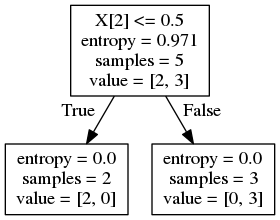

In [17]:

from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
dtc=DecisionTreeClassifier(criterion="entropy")
dtc.fit(X_train,y_train)

print("sklearn test:{}".format(dtc.predict([[5, 3, 3, 9]])))

from sklearn.tree import export_graphviz
import pydotplus

pic=export_graphviz(dtc,out_file=None)
graph=pydotplus.graph_from_dot_data(pic)
Image(graph.create_png())